# Plot QVA Deterministic

Plots a deterministic Quantitative Volcanic Ash Concentration forecast with the agreed colors per threshold:

| Threshold (mg/m3) | RGB            | Color name (approx) |
|-------------------|----------------|---------------------|
| [0.2 - 2[         | [160,210,255]  | blue                |
| [2 - 5[           | [255,153,0]    | orange              |
| [5 - 10[          | [255,40,0]     | red                 |
| >= 10             | [170,0,170]    | purple              |

Intervals are lower-bound inclusive, upper-bound exclusive.

The netcdf file used in this example (qva_det_Ruapehu_202501081200.nc), as well as this notebook are is available in https://github.com/rosatrancoso/notebook-share/blob/master/docs/qva/.

In [1]:
# Contents of the netcdf file
! ncdump -h qva_det_Ruapehu_202501081200.nc

netcdf qva_det_Ruapehu_202501081200 {
dimensions:
	time = UNLIMITED ; // (24 currently)
	latitude = 361 ;
	longitude = 441 ;
	levels = 12 ;
variables:
	float latitude(latitude) ;
		latitude:_FillValue = NaNf ;
		latitude:long_name = "latitude degrees north from the equator" ;
		latitude:units = "degrees_north" ;
		latitude:point_spacing = "even" ;
	float longitude(longitude) ;
		longitude:_FillValue = NaNf ;
		longitude:long_name = "longitude degrees east from the greenwich meridian" ;
		longitude:units = "degrees_east" ;
		longitude:point_spacing = "even" ;
	double levels(levels) ;
		levels:_FillValue = NaN ;
		levels:long_name = "Top of flight level layer" ;
		levels:units = "feet" ;
		levels:axis = "Z" ;
		levels:positive = "up" ;
	int64 time(time) ;
		time:axis = "T" ;
		time:long_name = "time" ;
		time:units = "hours since 2025-01-08T13:00:00" ;
		time:calendar = "proleptic_gregorian" ;
	float concentration(time, levels, latitude, longitude) ;
		concentration:_FillValue = NaNf ;
	

In [2]:
import numpy as np
import pandas as pd 
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl

import cartopy.crs as ccrs
import cartopy.feature as cf

from math import floor,ceil


# x-positions of gridlines (need to specify when over 180 deg)
xlocs = [100,110, 120, 130, 140, 150, 160, 170, 179.99999, -170, -160, -150, -140, -130, -120, -110, -100]

# central longitude for projection
clon = 180

# mask values below "numerical zero"
almost_zero = 1e-16


## Colormap settings

concentration thresholds (mg/m3)= [ 0.2  2.   5.  10. ]


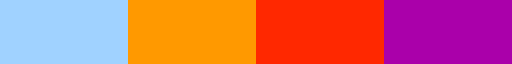

In [3]:

thresholds = np.array([0.2,2,5,10])
print(f'concentration thresholds (mg/m3)= {thresholds}')

# colors per threshold
colors_rgb= [
    [160,210,255], # blue
    [255,153,0], # orange
    [255,40,0], # red
    [170,0,170], # purple
]

# colormap
cmap = mpl.colors.ListedColormap(np.array(colors_rgb)/255)
cmap 

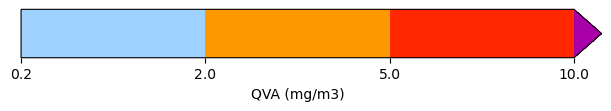

In [4]:
# without the `extend=max` option, the colorbar will not show the color for the pre-to-last value (red)

norm = mpl.colors.BoundaryNorm(thresholds,cmap.N, extend='max')

fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
             cax=ax, orientation='horizontal', label='QVA (mg/m3)')#, boundaries=thresholds, ticks=thresholds)


## Read input netcdf file

In [5]:
ds = xr.open_dataset('qva_det_Ruapehu_202501081200.nc')
ds

<xarray.Dataset> Size: 183MB
Dimensions:        (latitude: 361, longitude: 441, levels: 12, time: 24)
Coordinates:
  * latitude       (latitude) float32 1kB -84.28 -84.03 -83.78 ... 5.47 5.72
  * longitude      (longitude) float32 2kB 120.6 120.8 121.1 ... 230.3 230.6
  * levels         (levels) float64 96B 5e+03 1e+04 1.5e+04 ... 5.5e+04 6e+04
  * time           (time) datetime64[ns] 192B 2025-01-08T13:00:00 ... 2025-01...
Data variables:
    concentration  (time, levels, latitude, longitude) float32 183MB ...
Attributes:
    title:                            HYSPLIT Model Concentration Output
    Conventions:                      CF-1.5
    volcano_name:                     Ruapehu
    eruption_lon_degrees:             175.57
    eruption_lat_degrees:             -39.28
    eruption_vent_meters_msl:         2797.0
    eruption_height_meters_msl:       12500.0
    eruption_mass_eruption_rate_kgs:  87500.0
    eruption_start_time:              2025-01-08T12:00:00
    eruption_duration_s:              3600.0

### Get full extent of the plume at all levels and times

This helps to have the same zoom extent in all plots that fits the data.

In [6]:
# determine full extent of the plume at all levels and times
da = ds['concentration']
da_m = da.where(da > almost_zero, drop=True)
print(f'shape before mask = {da.shape}')
print(f'shape after mask  = {da_m.shape}')

bnd = [floor(da_m.longitude.values.min()), ceil(da_m.longitude.values.max()), 
       floor(da_m.latitude.values.min()), ceil(da_m.latitude.values.max())]
print(f'full extent of plume = {bnd}')

shape before mask = (24, 12, 361, 441)
shape after mask  = (24, 9, 44, 128)
full extent of plume = [174, 207, -40, -29]


### Get max concentration at each level

merely indicative to know where the ash is and plot relevant levels

Text(0.5, 1.0, 'Max concentration [mg/m3] at each level')

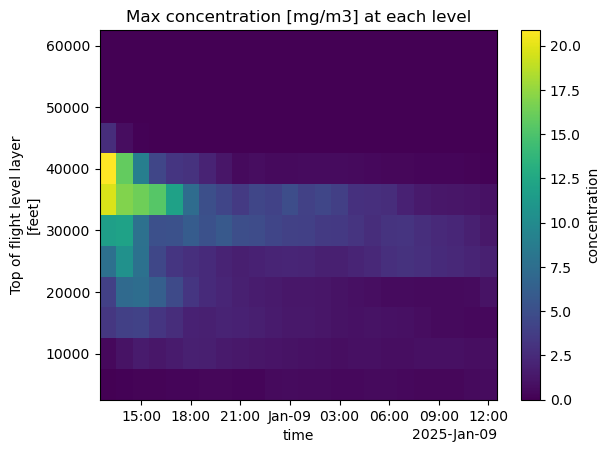

In [7]:
# determine max concentration at each level to help us plot interesting stuff
ds['concentration'].max(dim=('longitude', 'latitude')).plot(y='levels', x='time')
plt.title('Max concentration [mg/m3] at each level')

## Plot

Choose time and level to plot 

In [9]:
# time index
it = 11  

# level index of top of the layer
ilev  = 1

print(ds.time[it].values)
print(f'FL{ds.levels[ilev].values/100:.0f}')


2025-01-09T00:00:00.000000000
FL100


Prepare plot title

In [10]:
volcano_name = ds.attrs['volcano_name']
olon = ds.attrs['eruption_lon_degrees']
olat = ds.attrs['eruption_lat_degrees']
h_vent = ds.attrs['eruption_vent_meters_msl']
h_top = ds.attrs['eruption_height_meters_msl']
mer = ds.attrs['eruption_mass_eruption_rate_kgs']
dur = ds.attrs['eruption_duration_s']


time = pd.to_datetime(ds.time[it].values)
eruption_start_time = pd.to_datetime(ds.attrs['eruption_start_time'])
lead_time = (time - eruption_start_time).total_seconds()/3600.

level = ds.levels[ilev].values
level_below = ds.levels[ilev-1].values if ilev > 0 else 0

level = (level/100).astype(int)
level_below = (level_below/100).astype(int)

tit_str1 = f'{volcano_name} ({olon:.4f} E, {olat:.4f} N, {h_vent:.1f} m asl)' 
tit_str2 = f'H = {h_top/1000.:.1f} km asl; MER = {mer:.1e} kg/s, D = {dur/3600.:.0f} h'
tit_str3 = f'Valid at {time} (+{lead_time:.0f} h after eruption) for FL{level_below}-FL{level}'

tit_str = f'{tit_str1}\n{tit_str2}\n{tit_str3}'
print(tit_str)


Ruapehu (175.5700 E, -39.2800 N, 2797.0 m asl)
H = 12.5 km asl; MER = 8.8e+04 kg/s, D = 1 h
Valid at 2025-01-09 00:00:00 (+12 h after eruption) for FL50-FL100


Plot

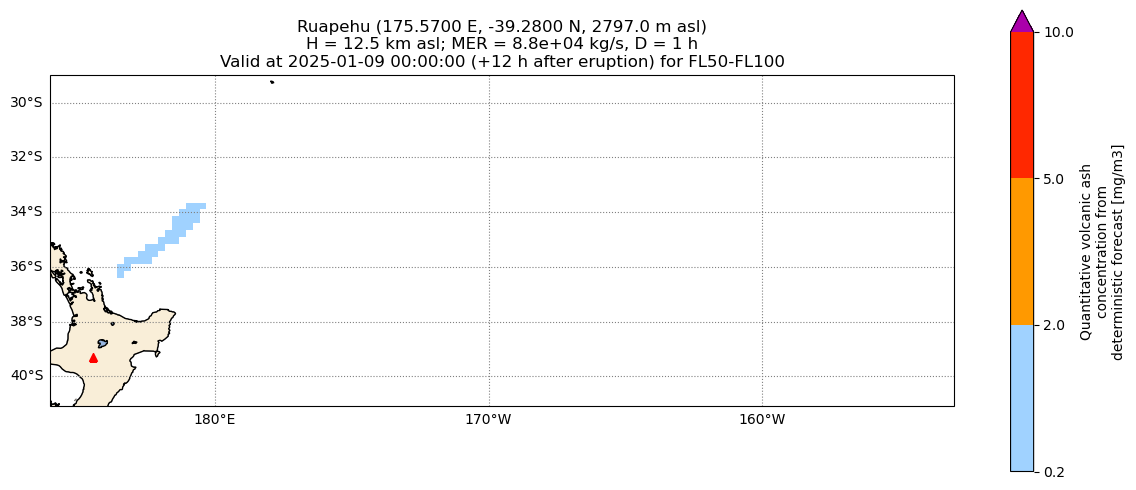

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12,5), subplot_kw={"projection": ccrs.PlateCarree(clon)})

da = ds['concentration'].isel(time=it, levels=ilev)

# need to mask to lower thredshold so that the lower limit of colorbar is correct (otherwise C < 0.2 will also be blue)
da_m = da.where(da >= thresholds[0])

# needs extend='max' so that it always plots the colorbar corretly, even if there little ash present (C < 10)
da_m.plot(ax=ax, norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), extend='max')

# add volcano location
ax.plot(olon, olat, marker='^' , color='r', transform=ccrs.PlateCarree())

# zoom in to see the data
ax.set_extent(bnd)
# ax.set_extent([175, 180, -40, -35])

# add decorations 
# ax.add_feature(cf.OCEAN)
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS, lw=0.5)
ax.add_feature(cf.LAND, edgecolor='black', facecolor='wheat', linewidth=0.5, alpha=0.5)
ax.add_feature(cf.LAKES, edgecolor='black', facecolor=cf.COLORS['water']) #'none')
if clon == 180:
    gl = ax.gridlines(xlocs=xlocs, draw_labels=True, ls=':', color='gray')
else:
    gl = ax.gridlines(draw_labels=True, ls=':', color='gray')

gl.top_labels = False
gl.right_labels = False

ax.set_title(tit_str)
fig.tight_layout()
